In [ ]:
!nvidia-smi

Sat Jan 30 06:12:17 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# https://github.com/42io/dataset/tree/master/google_speech_commands
# backward bed bird cat dog down eight five follow forward four go happy house 
# learn left marvin nine no off on one right seven sheila six stop three tree 
# two up visual wow yes zero
DATASET_FILE = '1kuQGsYMWFv0zNz8iSmcodwnhj7T0lXRE'

In [ ]:
!test -f "$DATASET_FILE" || gdown --id "$DATASET_FILE" -O "$DATASET_FILE"

Downloading...
From: https://drive.google.com/uc?id=1kuQGsYMWFv0zNz8iSmcodwnhj7T0lXRE
To: /content/1kuQGsYMWFv0zNz8iSmcodwnhj7T0lXRE
7.25GB [02:25, 49.7MB/s]


In [ ]:
md5 = !md5sum "$DATASET_FILE"
assert '93e4a84aecf58379a716ed8928afda58' == md5[0].split()[0], md5

In [ ]:
%tensorflow_version 2.x
import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras
import tensorflow as tf
print(tf.__version__)

2.4.1


In [ ]:
dset = np.load(DATASET_FILE)
print(dset['x_train'].shape)

(3072291, 637)


In [ ]:
labels = tuple(dset['labels'])
!echo "{'\n'.join(labels)}" | column

backward	five		learn		one		tree
bed		follow		left		right		two
bird		forward		marvin		seven		up
cat		four		nine		sheila		visual
dog		go		no		six		wow
down		happy		off		stop		yes
eight		house		on		three		zero


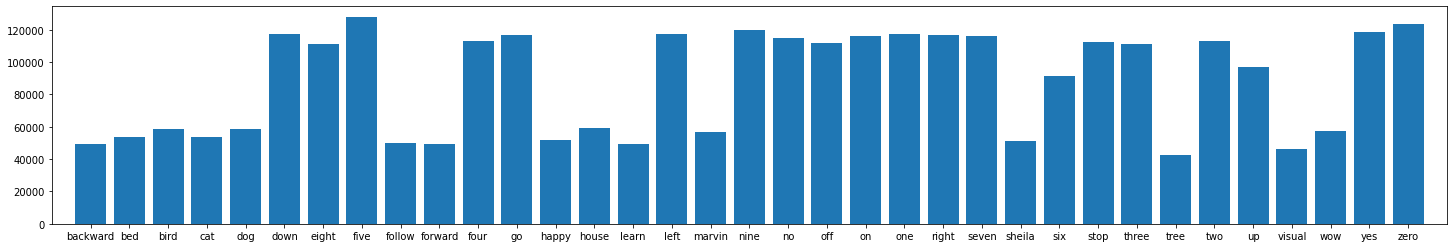

In [ ]:
plt.rc('figure', figsize=(25, 4))
plt.bar(list(range(len(labels))),
        [len(dset['y_train'][dset['y_train'] == i]) for i in range(len(labels))],
        tick_label=labels)
assert plt.xlim(-1, len(labels))

In [ ]:
x_train, x_test, x_valid = (
    dset[i].reshape(-1, 49, 1, 13)[:,1:-1]
    for i in ['x_train', 'x_test', 'x_valid']
)
y_train = dset['y_train']
y_test  = dset['y_test']
y_valid = dset['y_valid']

In [ ]:
def spectrogram_masking(spectrogram, dim=1, masks_number=2, mask_max_size=5):
  """Spectrogram masking on frequency or time dimension.
  Args:
    spectrogram: Input spectrum [batch, time, frequency]
    dim: dimension on which masking will be applied: 1 - time; 2 - frequency
    masks_number: number of masks
    mask_max_size: mask max size
  Returns:
    masked spectrogram
  """
  if dim not in (1, 2):
    raise ValueError('Wrong dim value: %d' % dim)
  input_shape = spectrogram.shape
  time_size, frequency_size = input_shape[1:3]
  dim_size = input_shape[dim]  # size of dimension on which mask is applied
  stripe_shape = [1, time_size, frequency_size]
  for _ in range(masks_number):
    mask_end = tf.random.uniform([], 0, mask_max_size, tf.int32)
    mask_start = tf.random.uniform([], 0, dim_size - mask_end, tf.int32)

    # initialize stripes with stripe_shape
    stripe_ones_left = list(stripe_shape)
    stripe_zeros_center = list(stripe_shape)
    stripe_ones_right = list(stripe_shape)

    # update stripes dim
    stripe_ones_left[dim] = dim_size - mask_start - mask_end
    stripe_zeros_center[dim] = mask_end
    stripe_ones_right[dim] = mask_start

    # generate mask
    mask = tf.concat((
        tf.ones(stripe_ones_left, spectrogram.dtype),
        tf.zeros(stripe_zeros_center, spectrogram.dtype),
        tf.ones(stripe_ones_right, spectrogram.dtype),
    ), dim)
    spectrogram = spectrogram * mask
  return spectrogram

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(len(x_train))
train_dataset = train_dataset.batch(128)
train_dataset = train_dataset.map(lambda x, y: (tf.squeeze(x, -2), y))
train_dataset = train_dataset.map(lambda x, y: (spectrogram_masking(x, 1, 3, 3), y))
train_dataset = train_dataset.map(lambda x, y: (spectrogram_masking(x, 2, 2, 2), y))
train_dataset = train_dataset.map(lambda x, y: (tf.expand_dims(x, -2), y))

In [ ]:
del dset, x_train, y_train # free RAM to fit in 25 GB google colab

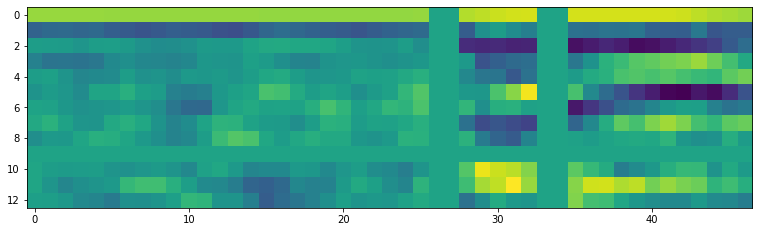

In [ ]:
plt.rc('figure', figsize=(13, 4))
assert plt.imshow(list(train_dataset.take(1))[0][0][0].numpy().squeeze().T)

In [ ]:
def build_model():

  x_in = x = keras.Input([47, 1, 13])

  x = keras.layers.Conv2D(64, 1, use_bias=False)(x)
  x = keras.layers.BatchNormalization()(x)
  x = keras.layers.ReLU()(x)

  for i in range(4):
    x = keras.layers.SeparableConv2D(x.shape[-1], kernel_size=[2, 1], 
                                     dilation_rate=[2**i, 1],
                                     use_bias=False)(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.ReLU()(x)

  x = keras.layers.AveragePooling2D([x.shape[1], 1])(x)
  x = keras.layers.Flatten()(x)

  x = keras.layers.Dense(x.shape[-1] // 2, use_bias=False)(x)
  x = keras.layers.BatchNormalization()(x)
  x = keras.layers.ReLU()(x)

  x = keras.layers.Dense(len(labels), activation='softmax')(x)

  model = keras.Model(inputs=x_in, outputs=x)

  model.summary()

  return model

In [ ]:
model = build_model()

model.compile(loss=keras.losses.sparse_categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 47, 1, 13)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 47, 1, 64)         832       
_________________________________________________________________
batch_normalization (BatchNo (None, 47, 1, 64)         256       
_________________________________________________________________
re_lu (ReLU)                 (None, 47, 1, 64)         0         
_________________________________________________________________
separable_conv2d (SeparableC (None, 46, 1, 64)         4224      
_________________________________________________________________
batch_normalization_1 (Batch (None, 46, 1, 64)         256       
_________________________________________________________________
re_lu_1 (ReLU)               (None, 46, 1, 64)         0     

In [ ]:
early_stopping = keras.callbacks.EarlyStopping(
        monitor='val_loss',
        mode='min',
        verbose=1,
        patience=100,
        restore_best_weights=True)

history = model.fit(train_dataset,
                    validation_data=(x_valid, y_valid),
                    callbacks=[early_stopping],
                    verbose=2,
                    epochs=100500)

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


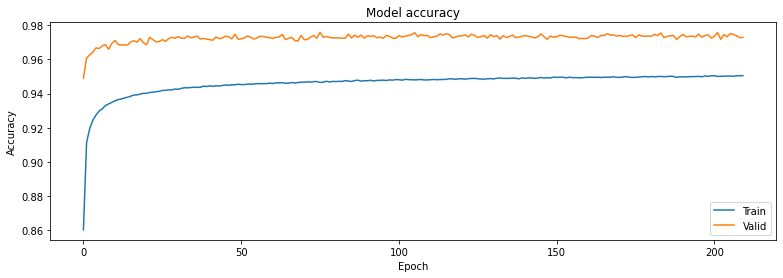

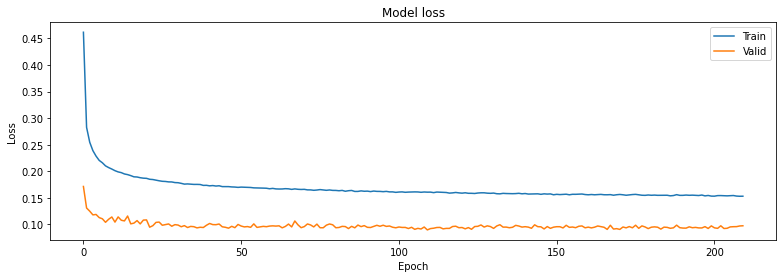

In [ ]:
print(history.history.keys())

import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='lower right')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper right')
plt.show()

In [ ]:
results = model.evaluate(train_dataset, verbose=0)
print('train loss, train acc:', results)

results = model.evaluate(x_test, y_test, verbose=0)
print('test loss, test acc:', results)

results = model.evaluate(x_valid, y_valid, verbose=0)
print('valid loss, valid acc:', results)

train loss, train acc: [0.18400651216506958, 0.9412767291069031]
test loss, test acc: [0.11645420640707016, 0.9651033282279968]
valid loss, valid acc: [0.08953282237052917, 0.9741390943527222]


In [ ]:
assert len(x_test) + len(x_valid) == 15312
pred = model.predict(x_test).argmax(axis=-1)
print(np.sum(pred != y_test), len(pred))
pred = model.predict(x_valid).argmax(axis=-1)
print(np.sum(pred != y_valid), len(pred))

282 8081
187 7231


In [ ]:
emb_model = keras.Sequential(model.layers[:-1])
emb_model.summary()
emb_model.save_weights('embedding.weights.h5')

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 47, 1, 64)         832       
_________________________________________________________________
batch_normalization (BatchNo (None, 47, 1, 64)         256       
_________________________________________________________________
re_lu (ReLU)                 (None, 47, 1, 64)         0         
_________________________________________________________________
separable_conv2d (SeparableC (None, 46, 1, 64)         4224      
_________________________________________________________________
batch_normalization_1 (Batch (None, 46, 1, 64)         256       
_________________________________________________________________
re_lu_1 (ReLU)               (None, 46, 1, 64)         0         
_________________________________________________________________
separable_conv2d_1 (Separabl (None, 44, 1, 64)         4

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!md5sum 'embedding.weights.h5'
!mv 'embedding.weights.h5' '/content/drive/My Drive/'

163f65d4d79388ce7da889699b9bc131  embedding.weights.h5
